In [1]:
import h5py
import pylab as pl
import numpy as np
import scipy.stats as sp
import matplotlib as mpl
import matplotlib.colors as mpc
import networkx
import progressbar
import astropy.cosmology as apc

In [2]:
def split_unique_id(unique_id):
    """Splits the ids assign to the subhalos by the merger tree code by snap number and subfind number """
    subfind_number = int(unique_id % 1e6)
    snap_number = int((unique_id - subfind_number) / 1e6)
    
    return snap_number, subfind_number

def get_main_branch_unique_ids(subtree, node):
    """Gets the unique ids of the subhalos belonging to the main branch of the selected subhalo (node)"""
    mpb = [node, ]
    i = 0
    while True:
        succesors = list(subtree.successors(node))
        if len(succesors) == 0:
            break
        node = succesors[0] # select only the first succesor (main branch)
        mpb.append(node)
        
    return mpb

In [3]:
pl.rc('font', size = 20)
pl.rc('legend', fontsize = 20)
sim = h5py.File('/data/cielo/simulations/LG1/LG1.hdf5', 'r')
trees = networkx.read_multiline_adjlist('/data/cielo/simulations/LG1/LG1_tree.dat')

In [4]:
Slist = h5py.File('SatelliteList_V2_withAngles_n500.h5', 'r')
Satellites = Slist['SatelliteList'][()]
Centrals = Slist['SatelliteCentral'][()]
CosCen = Slist['CosCen'][()]
CosVel = Slist['CosVel'][()]
#LzL = Slist['LZ_L'][()]
Satellites.size

19

In [5]:
# a bunch of constants
UnitMass_in_g = 1.989e+43
UnitTime_in_s = 3.08568e+16
UnitVelocity_in_cm_per_s = 100000
UnitDensity_in_cgs = 6.7699e-22
UnitEnergy_in_cgs = 1.989e+53
GAMMA_MINUS1 = 2./3.
PROTONMASS = 1.6726e-24
BOLTZMANN = 1.3806e-16    

HMass = 1.00794
FeMass = 55.845
OMass = 15.9994
NfeNhe_sun = -4.5 # grevesse & saundall 98
NoNfe_sun = 1.33 # same

def tempFromMass(Mass, Abund, IE, ne1):
    XH = Abund[:,6]/Mass
    yHelium = (1. - XH)/(4.*XH)
    mu = (1 + 4.* yHelium)/ (1.+ yHelium + ne1 )
    temp = GAMMA_MINUS1 * IE * mu * 1.6726 / 1.3806 * 1.e-8 # / BOLTZMANN  * PROTONMASS
    temp = temp * 1e10 #   UnitEnergy_in_cgs / UnitMass_in_g;
    return temp

In [6]:
#ok, now the serialized version of the get particles for each Satellite, lets see.
TdayTotalIDs = sim['SnapNumber_128/PartType0/ParticleIDs'][()] # need this first
I= np.identity(3) # and this

In [7]:
def getAllLastP(fofID, centralID):
    """
    get position, masses and abundances of all particles that in past snapshot belong to a given subhalo,
    and a z=0 are located at athe maximum distance of 600 kpc to the subhalo,
    rotated by the velocity and the vector to the centre.
    """
    uniqueID = int(128*1e6+fofID)
    stree = networkx.dfs_tree(trees, str(uniqueID))
    mtree = get_main_branch_unique_ids(stree, str(uniqueID))
    
    uniqueIDC = int(128*1e6+centralID)
    streeC = networkx.dfs_tree(trees, str(uniqueIDC))
    mtreeC = get_main_branch_unique_ids(streeC, str(uniqueIDC))
    
    #firts find all the particleIDs that once belong to the subgroup
    Idlist = []
    templist = []
#     templist2 = []
    
    for mm, mmC in zip(mtree[1:], mtreeC[1:]): # ignore the first one
        snap, idd = split_unique_id(int(mm))
        tempOff = sim['SnapNumber_{}/SubGroups/PartType0/Offsets'.format(snap)][idd].astype('int')
        snapC, iddC = split_unique_id(int(mmC))
        if tempOff[0]>= 0 and tempOff[1]>=0:
            tempIds = sim['SnapNumber_{}/PartType0/ParticleIDs'.format(snap)][tempOff[0]:tempOff[1]]
#             # and the temperature
#             IE = sim['SnapNumber_{}/PartType0/InternalEnergy'.format(snap)][tempOff[0]:tempOff[1]]
#             Mass = sim['SnapNumber_{}/PartType0/Masses'.format(snap)][tempOff[0]:tempOff[1]]
#             Abund = sim['SnapNumber_{}/PartType0/Abundances'.format(snap)][tempOff[0]:tempOff[1]]
#             ne1 = sim['SnapNumber_{}/PartType0/ElectronAbundance'.format(snap)][tempOff[0]:tempOff[1]]
#             val2 = tempFromMass(Mass, Abund, IE, ne1)
#             templist2.extend(list(val2))
            # and the metallicity
#             AbundatTime = sim['SnapNumber_{}/PartType0/Abundances'.format(snap)][tempOff[0]:tempOff[1]]
#             val = np.log10((AbundatTime[:,4]/FeMass)/(AbundatTime[:,6]/HMass)) - NfeNhe_sun
#             val = (AbundatTime[:,4]/FeMass)/(AbundatTime[:,6]/HMass)
#             templist.extend(list(val))
            #zz = sim['SnapNumber_{}/Header/Redshift'.format(snap)][()]
            #templist.extend([zz]*tempIds.size)
            # and the distance to the centre (of the galaxy in virial radius units)
            galP = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][idd]
            cenP = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][iddC]
            gro = sim['SnapNumber_{}/SubGroups/GroupNumber'.format(snap)][iddC]
            R200 = sim['SnapNumber_{}/Groups/Group_R_Crit200'.format(snap)][gro]
            
            defe = cenP - galP
            dist = np.sqrt(np.sum(defe**2.))/R200
            
            templist.extend([dist]*tempIds.size)
            
            Idlist.extend(list(tempIds))

    Idlist = np.array(Idlist)
    templist = np.array(templist)
#     templist2 = np.array(templist2)
    
    Idlist, Idunique = np.unique(Idlist, return_index=True) # remove duplicates
    templist = templist[Idunique]
#     templist2 = templist2[Idunique]
    
    TdayOff = sim['SnapNumber_128/SubGroups/PartType0/Offsets'][fofID].astype('int')
    
    IndexToday = np.in1d(TdayTotalIDs, Idlist)
    IndexToday_ = np.where(IndexToday)[0]
    
    # lets remove the ones that are not part of the group today.
    TdayIDs = sim['SnapNumber_128/PartType0/ParticleIDs'][TdayOff[0]:TdayOff[1]]

    IndexNot = np.in1d(Idlist, TdayIDs)
    IdNot = Idlist[np.where(IndexNot==False)[0]]

    IndexT = np.in1d(TdayTotalIDs, IdNot)
    IndexT_ = np.where(IndexT)[0]
    
    # and temperature
    SurvIds_ = TdayTotalIDs[IndexT_]
    iidex = np.in1d(Idlist, SurvIds_)
    iidex_ = np.where(iidex)[0]
    templist_, Idlist_ = templist[iidex_], Idlist[iidex_]
#     templist2_ = templist2[iidex_]

    is1 = np.argsort(SurvIds_) # the target
    is2 = np.argsort(Idlist_)

    temporder = np.zeros(IndexT_.size)
    
    temporder[is1] = templist_[is2]
    
#     temporder2 = np.zeros(IndexT_.size)
#     temporder2[is1] = templist2_[is2]
    
    #now lets cut at  a certain distance
    #distance = 600 # distance in ckpc
    distance = 200 
    
    posGal = sim['SnapNumber_128/SubGroups/SubGroupPos'][fofID]
    posCen = sim['SnapNumber_128/SubGroups/SubGroupPos'][centralID]

    LostCoord = sim['SnapNumber_128/PartType0/Coordinates'][IndexT_]
    
    dx, dy, dz = LostCoord[:,0]-posGal[0], LostCoord[:,1]-posGal[1], LostCoord[:,2]-posGal[2]
    distToC = np.sqrt(dx**2+dy**2+dz**2)

    icut = np.where(distToC<distance)[0]
    IndexT_near = IndexT_[icut] # this is the final list of particles ids
    temporder_near = temporder[icut]
#     temporder_near2 = temporder2[icut]
    
    # ok, lest see velocity and stuff
#     velCen = sim['SnapNumber_128/SubGroups/SubGroupVel'][centralID]
#     velSat = sim['SnapNumber_128/SubGroups/SubGroupVel'][fofID]

#     velRep = velSat - velCen
    
    GasMasses = sim['SnapNumber_128/PartType0/Masses'][IndexT_near]
    GassAbundances = sim['SnapNumber_128/PartType0/Abundances'][IndexT_near]
    
#     NearCoord = sim['SnapNumber_128/PartType0/Coordinates'][IndexT_near]

#     IE0 = sim['SnapNumber_128/PartType0/InternalEnergy'][IndexT_near]
#     ne10 = sim['SnapNumber_128/PartType0/ElectronAbundance'][IndexT_near]
#     t0 = tempFromMass(GasMasses, GassAbundances, IE0, ne10)
    
#     temporder_near = temporder_near - t0
#     temporder_near = t0 # not so subtle replacement
#     # first lets re-define coordinates in a galactocentric scheme.
#     X, Y, Z = NearCoord[:,0] - posGal[0], NearCoord[:,1] - posGal[1], NearCoord[:,2] - posGal[2]
#     xC, yC, zC = posCen[0] - posGal[0], posCen[1] - posGal[1], posCen[2] - posGal[2] # the direction of the centre from the galaxy
    
#     # now define normalized vectors, for velocity and centre directions
#     velX, velY, velZ = velRep[0], velRep[1], velRep[2]
#     Vel = np.sqrt(velX**2 + velY**2 + velZ**2)
#     Cen = np.sqrt(xC**2 + yC**2 + zC**2)

#     velx, vely, velz = velX/Vel, velY/Vel, velZ/Vel
#     xc, yc, zc = xC/Cen, yC/Cen, zC/Cen
    
#     # Then, the rotations matrix are, for velocity
#     faV = (1-velx)/(vely**2 + velz**2)
#     VV = np.array([[0, vely, velz], [-vely, 0, 0], [-velz, 0, 0]])
#     VV2 = np.matmul(VV, VV)

#     RV = I + VV + VV2*faV
    
#     # and for the direction to the centre
#     faC = (1-xc)/(yc**2+zc**2)
#     CC = np.array([[0, yc, zc], [-yc, 0, 0], [-zc, 0, 0]])
#     CC2 = np.matmul(CC, CC)

#     RC = I + CC + CC2*faC
    
#     # lets calculate the rotated coordinates
#     xRv, yRv, zRv = [], [], []
#     xRc, yRc, zRc = [], [], []

#     for x, y, z in zip(X, Y, Z):
#         dV = np.matmul(RV, np.array([x, y, z]))
#         dC = np.matmul(RC, np.array([x, y, z]))
    
#         xRv.append(dV[0])
#         yRv.append(dV[1])
#         zRv.append(dV[2])
    
#         xRc.append(dC[0])
#         yRc.append(dC[1])
#         zRc.append(dC[2])
    
#     xRv, yRv, zRv = np.array(xRv), np.array(yRv), np.array(zRv)
#     xRc, yRc, zRc = np.array(xRc), np.array(yRc), np.array(zRc)
    
#     # now, I only need one number, the cos stuff
#     cosC = xRc/np.sqrt(xRc**2.+yRc**2.+zRc**2.)
#     cosV = xRv/np.sqrt(xRv**2.+yRv**2.+zRv**2.)
    
    # and return the 2 sets of rotated positions, masses and abundances
#     return cosV, cosC, GasMasses, GassAbundances, temporder_near, temporder_near2
    return GasMasses, GassAbundances, temporder_near

Text(0.5, 0, 'r/r_200')

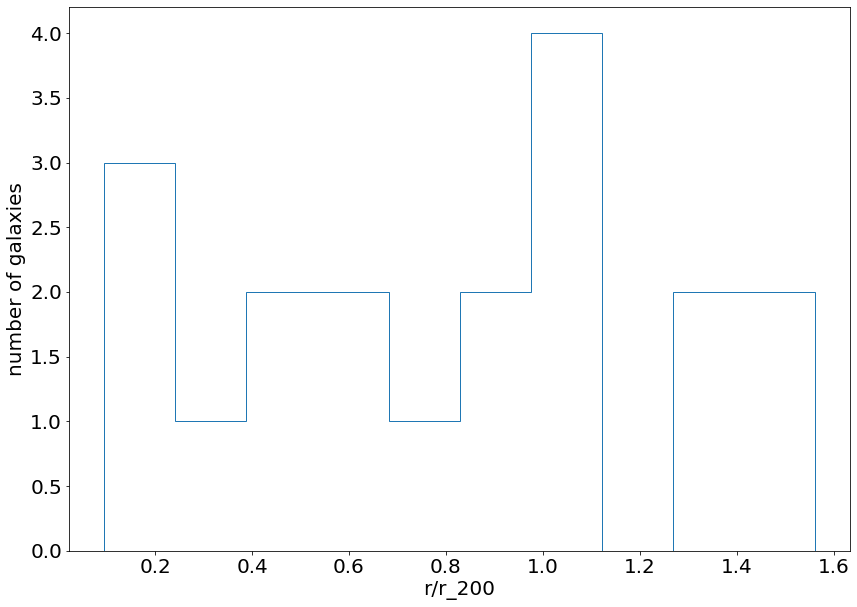

In [8]:
# lets test somo clean up by separation.
R200, GalCen, GroCen = [], [], []

for ss, cc in zip(Satellites, Centrals):
    group = sim['SnapNumber_128/SubGroups/GroupNumber'][cc]
    r200 = sim['SnapNumber_128/Groups/Group_R_Crit200'][group]
    galCen = sim['SnapNumber_128/SubGroups/SubGroupPos'][ss]
    groCen = sim['SnapNumber_128/SubGroups/SubGroupPos'][cc]
    
    R200.append(r200)
    GalCen.append(galCen)
    GroCen.append(groCen)

R200, GalCen, GroCen = np.array(R200), np.array(GalCen), np.array(GroCen)

sep = GalCen - GroCen
dist = np.sqrt(sep[:,0]**2+sep[:,1]**2+sep[:,2]**2)
dist = dist/R200

# Satellites = Slist['SatelliteList'][()]
# Centrals = Slist['SatelliteCentral'][()]
# CosCen = Slist['CosCen'][()]
# CosVel = Slist['CosVel'][()]
# LzL = Slist['LZ_L'][()]

pl.figure(figsize=(14, 10))

pl.hist(dist, histtype='step')
pl.ylabel('number of galaxies')
pl.xlabel('r/r_200')

In [9]:
ir = np.where(dist>0.5)

Satellites = Satellites[ir]
Centrals = Centrals[ir]
CosCen = CosCen[ir]
CosVel = CosVel[ir]
#LzL = LzL[ir]

Satellites.size, CosCen.min()

(14, -0.9617047452183579)

In [10]:
#all
size = Satellites.size

bar = progressbar.ProgressBar(max_value=size)
C, passs = 0, 0

# CosRv, CosRc, GASMasses, GASAbundances, temp, temp2 = [], [], [], [], [], []
# CosRv, CosRc, GASMasses, GASAbundances, temp = [], [], [], [], []
GASMasses, GASAbundances, temp = [], [], []

StarMass = []

for ff, cc in zip(Satellites, Centrals):
#     try:
#     cosRv, cosRc, GasMasses, GasAbundances, ttemp, ttemp2 = getAllLastP(ff, cc)
#     cosRv, cosRc, GasMasses, GasAbundances, ttemp = getAllLastP(ff, cc)
    GasMasses, GasAbundances, ttemp = getAllLastP(ff, cc)
    passs += 1
#     except:
#         C += 1
#         continue
        
#     CosRv.extend(list(cosRv))
#     CosRc.extend(list(cosRc))
    GASMasses.extend(list(GasMasses))
    GASAbundances.extend(list(GasAbundances))
    temp.extend(list(ttemp))
#     temp2.extend(list(ttemp2))
    
    # and star masses
    offst = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][ff].astype('int')
    STMass = sim['SnapNumber_128/PartType4/Masses'][offst[0]:offst[1]]
    STM = np.sum(STMass)
    
    StarMass.extend([STM]*GasMasses.size)
    
    C += 1
    bar.update(C)
    
# CosRv, CosRc, GASMasses, GASAbundances = np.array(CosRv), np.array(CosRc), np.array(GASMasses), np.array(GASAbundances)
GASMasses, GASAbundances = np.array(GASMasses), np.array(GASAbundances)

StarMass = np.array(StarMass)
temp = np.array(temp)
# temp2 = np.array(temp2)
passs

100% (14 of 14) |########################| Elapsed Time: 0:03:14 ETA:  00:00:00

14

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


Text(0, 0.5, '[O/Fe]')

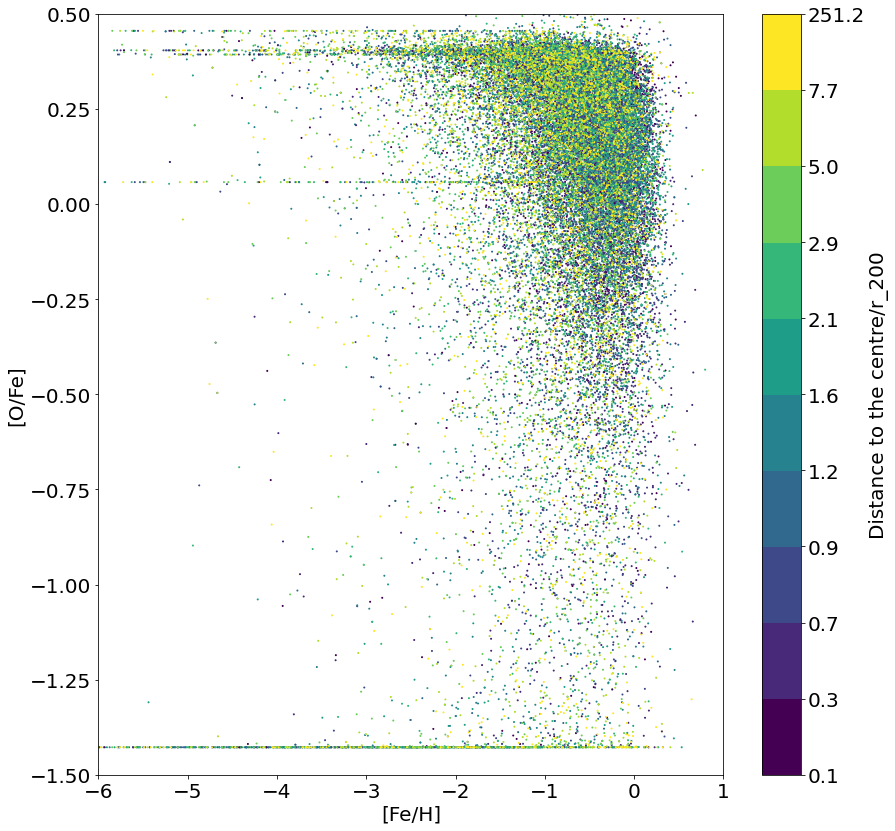

In [11]:
pl.figure(figsize=(14, 14))

pl.subplots_adjust(wspace=0.32)

FeH = np.log10((GASAbundances[:,4]/FeMass)/(GASAbundances[:,6]/HMass)) - NfeNhe_sun
OFe = np.log10((GASAbundances[:,3]/OMass)/(GASAbundances[:,4]/FeMass)) - NoNfe_sun


i = np.where((np.isinf(FeH)==False) & (np.isnan(FeH)==False) & (np.isinf(OFe)==False) & (np.isnan(OFe)==False))
FeH_ = FeH[i]
OFe_ = OFe[i]
temp_ = temp[i]

vaper = np.linspace(0, 100, 11)
papels = np.percentile(temp_, vaper)
norm = mpc.BoundaryNorm(boundaries=papels, ncolors=256)

pl.scatter(FeH_, OFe_, c=temp_, s=1, norm=norm)

bar = pl.colorbar(label='Distance to the centre/r_200')
bar.set_ticks(papels)

pl.xlim(-6,1)
pl.ylim(-1.5,.5)

pl.xlabel('[Fe/H]')
pl.ylabel('[O/Fe]')

Text(0, 0.5, '[O/Fe]')

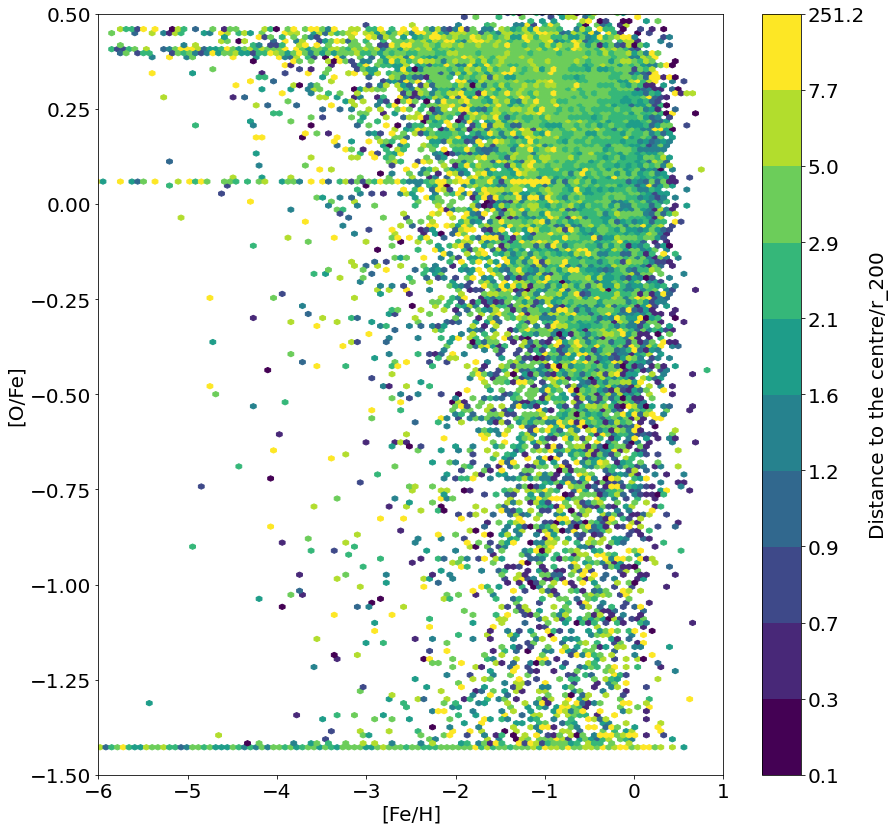

In [12]:
pl.figure(figsize=(14, 14))

pl.hexbin(FeH_, OFe_, C=temp_, norm=norm, gridsize=200)

bar = pl.colorbar(label='Distance to the centre/r_200')
bar.set_ticks(papels)

pl.xlim(-6,1)
pl.ylim(-1.5,.5)

pl.xlabel('[Fe/H]')
pl.ylabel('[O/Fe]')

In [13]:
# with h5py.File('SatelliteList_1stInfall_n500_KoK04.h5', 'w') as f:
#     f.create_dataset('SatelliteList', data=sat_1)
#     f.create_dataset('SatelliteCentral', data=cent_1)

In [14]:
sim['SnapNumber_128/PartType0/StarFormationRate'].attrs['description_units']

'$M_\\odot yr^{-1}$'

In [15]:
FeH_.size

42141

In [16]:
i = np.where((FeH_>-6) & (FeH_<1) & (OFe_<.5) & (OFe_>-1.5))[0]
i.size


41838

In [17]:
32661, 32413

(32661, 32413)

98